<span style="color:red">Abgegeben von (Name, Vorname):</span> 
**Elsherif, Mohamed**

<br>
<font size="6"><strong>5. Sitzung: WordNet II – Distanz- und Ähnlichkeitsmaße </strong></font> 
<br>
<br>

Für dieses Notebook gibt es eine begeleitendes Skript auf Ilias: `skript-wordnet.pdf`

Die Basiselemente von [WordNet](https://wordnet.princeton.edu) wurde in der letzten Sitzung bereits vorgestellt. In dieser Sitzung beschäftigen wir uns mit dem (indirekten) Verhältnis zwischen den Synsets in WordNet, wie wir damit die konzeptuelle Ähnlichkeit bemessen und schließlich **ein Wort in einem Satz disambiguieren** können.

<div>
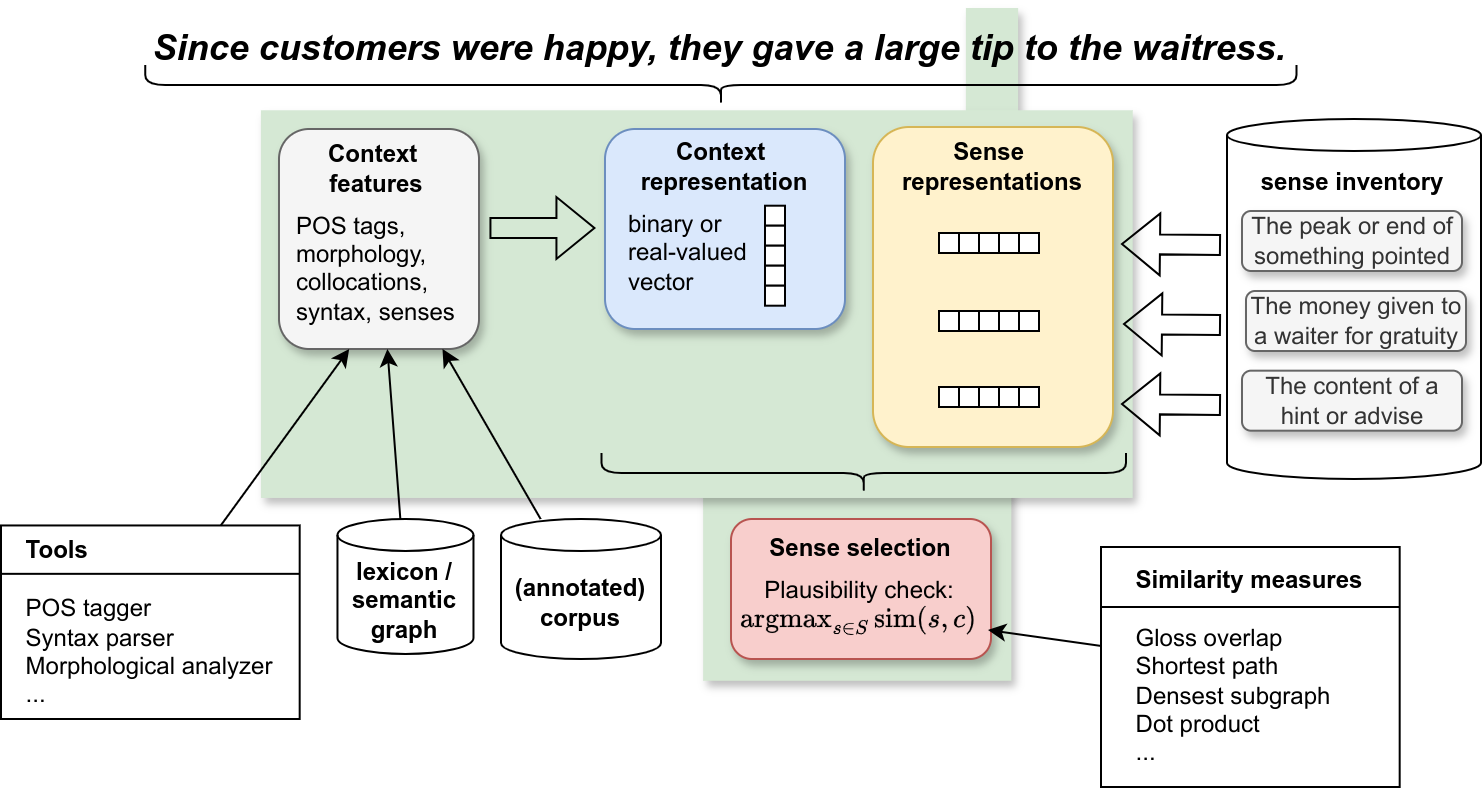
</div>

Wir importieren wie gewohnt das WordNet-Modul von NLTK. 

In [1]:
import nltk
from nltk.corpus import wordnet as wn

Immer griffbereit:
- Website: https://www.nltk.org/
- Buch: https://www.nltk.org/book/
- Module: https://www.nltk.org/py-modindex.html
- Beispiele: http://www.nltk.org/howto/

# Distanzmaße: Minimale Pfadlänge

Die Synsets in WordNet sind über Relationskanten (Hyponomie, Hyperonymie, Meronymie, Antonymie, ...) verbunden, die als Sequenz einen sogenannten **Pfad** bilden. Da wir es hier mit einem Graphen zu tun haben, kann es mehrere solcher Pfade geben (im Unterschied zu Bäumen). 

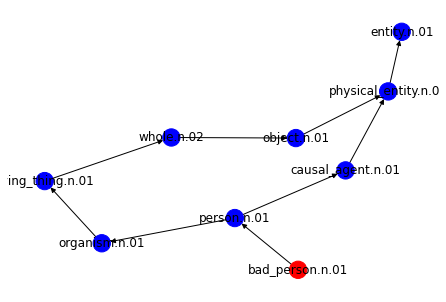

Am interessantesten ist sicherlich der kürzeste Pfad zwischen zwei Synsets: 

$$pathlen(s_1 ,s_2 ) = \text{die Anzahl der Kanten im kürzesten Pfad zwischen } s_1 \text{ und }
s_2$$

NLTK stellt hier die Methode `shortest_path_distance()` für Synset-Objekte zur Verfügung. Aber **Vorsicht**: `shortest_path_distance()` betrachtet nur die Hyponomiepfade zum nächsten gemeinsamen Hypernym!

In [2]:
print("Ergebnisse von shortest_path_distance() bei unterschiedlichen Relationstypen:")
print("- gemeinsames direktes Hyponym: {}".format(wn.synset('organism.n.01').shortest_path_distance(wn.synset('causal_agent.n.01'))))
print("- Hyponymie: {}".format(wn.synset('bank.n.01').shortest_path_distance(wn.synset('waterside.n.01'))))
print("- Meronymie: {}".format(wn.synset('water.n.01').shortest_path_distance(wn.synset('oxygen.n.01'))))
print("- Antonymie: {}".format(wn.synset('living.n.02').shortest_path_distance(wn.synset('dead.n.01'))))
print("- Derivationally related: {}".format(wn.synset('decision.n.01').shortest_path_distance(wn.synset('decide.v.01'))))

Ergebnisse von shortest_path_distance() bei unterschiedlichen Relationstypen:
- gemeinsames direktes Hyponym: 5
- Hyponymie: 1
- Meronymie: 4
- Antonymie: 2
- Derivationally related: None


Im letzten Notebook wurde ausführlich dargestellt, dass ein Synset u.a. aus einer Menge von **Lemmata** besteht, und dass ein Lemma mit mehr als einem Synset assoziert sein kann. (Bitte beachten, dass Lexeme (= Lemma + Bedeutung) in unseren Notebooks als als WN-Lemmata bezeichnet werden.) 

Wenn also nach dem kürzesten Pfad zwischen zwei Lemmata gefragt wird, müssen erst einmal alle assoziierten Synsets (d.h. ihre Bedeutungen) ermittelt werden. Darum soll es in der nächsten Aufgabe gehen. 

## <span style="color:red">Aufgaben I</span>

<span style="color:red">A1:</span> Schreiben Sie eine Funktion `shortest_path_distance_of_lemmas(lemma1,lemma2)`, die für zwei **Lemmaformen** `lemma1` und `lemma2` den kürzesten Hyponomie-Pfad als ganze Zahl und die entsprechenden Synset-Namen ausgibt! 

$$shortest\_path\_distance\_of\_lemmas(l_1,l_2) = \min_{s_1 \in synsets(l_1)\\s_2 \in synsets(l_2)} shortest\_path\_distance(s_1,s_2)$$

Verwenden Sie als Ausgabeformat eine Liste mit drei Elementen `[LENGTH, SYNSET1, SYNSET2]`:

    shortest_path_distance_of_lemmas('bank','waterside') -->  [1,'bank.n.01','waterside.n.01']



In [3]:
# Lösung A1

def shortest_path_distance_of_lemmas(lemma1, lemma2):
    outsp = 1000
    outs1 = ''
    outs2 = ''

    # Lösung A1
    
    # alle synsets associated with lemma1 and lemma2 erhalten 
    synsets1 = wn.synsets(lemma1)
    synsets2 = wn.synsets(lemma2)
    
    # Alle Kombinationen von Synsets durchlaufen
    for s1 in synsets1:
        for s2 in synsets2:
            # Die shortest path distance berechnen
            distance = s1.shortest_path_distance(s2)
            if distance is not None and distance < outsp:
                outsp = distance           # die shortest path updaten
                outs1 = s1.name()          # die synset name for lemma1 speichern 
                outs2 = s2.name()          # die synset name for lemma2 speichern
    
    # Behandlung von Fällen, in denen kein Pfad gefunden wird
    if outsp == float('inf'):
        outsp = None

    return [outsp, outs1, outs2]

In [4]:
# Test für A1 (nicht verändern)

testpairs = [
    ('bank', 'waterside'),
    ('bat', 'sports'),
    ('rock', 'music'),
    ('fly', 'organism')
]


["{:10}, {:10}: {}".format(lemma1, lemma2, shortest_path_distance_of_lemmas(lemma1, lemma2))
    for lemma1, lemma2
    in testpairs]

["bank      , waterside : [1, 'bank.n.01', 'waterside.n.01']",
 "bat       , sports    : [4, 'bat.n.02', 'sport.n.01']",
 'rock      , music     : [3, "rock_\'n\'_roll.n.01", \'music.n.01\']',
 "fly       , organism  : [5, 'fly.n.03', 'organism.n.01']"]

Sind alle ausgegebenen Synset-Paare plausibel? Sie können dies mit `wn.synset('synset').definition()`überprüfen.
<div class="alert alert-block alert-success"> Ja, alle außer fly -> fly.n.03 sind plausibel. Sehen Sie die nächste zelle</div>

In [5]:
#### EINE ZUSÄTZLICHE ZELLE, DIE ICH ALS ANTWORT AUF DIE OBIGE ZEILE HINZUGEFÜGT HABE ####
for lemma1, lemma2 in testpairs:
    distance, synset1, synset2 = shortest_path_distance_of_lemmas(lemma1, lemma2)
    if synset1 and synset2:
        print(f"{lemma1} -> {synset1}: {wn.synset(synset1).definition()}")
        print(f"{lemma2} -> {synset2}: {wn.synset(synset2).definition()}")
        print(f"Shortest path distance: {distance}")
        print("-" * 50)
    else:
        print(f"No valid Synsets found for {lemma1} and {lemma2}.")

### Alle außer fly -> fly.n.03 sind plausibel.

bank -> bank.n.01: sloping land (especially the slope beside a body of water)
waterside -> waterside.n.01: land bordering a body of water
Shortest path distance: 1
--------------------------------------------------
bat -> bat.n.02: (baseball) a turn trying to get a hit
sports -> sport.n.01: an active diversion requiring physical exertion and competition
Shortest path distance: 4
--------------------------------------------------
rock -> rock_'n'_roll.n.01: a genre of popular music originating in the 1950s; a blend of black rhythm-and-blues with white country-and-western
music -> music.n.01: an artistic form of auditory communication incorporating instrumental or vocal tones in a structured and continuous manner
Shortest path distance: 3
--------------------------------------------------
fly -> fly.n.03: an opening in a garment that is closed by a zipper or by buttons concealed under a fold of cloth
organism -> organism.n.01: a living thing that has (or can develop) the ability to act o

# Ähnlichkeitsmaße

Es gibt eine Reihe von Metriken, die die semantische Ähnlichkeit oder semantische Nähe von zwei Synsets bemessen soll. 

## Pfadbasiert

Die Pfadlänge an sich ist ein wichtiger und einfacher Indikator für die semantische Ähnlichkeit oder semantische Nähe von zwei Synsets: Je kleiner die (kleinste) Pfadlänge, desto ähnlicher sind die Synsets und die enthaltenen Lexeme/WN-Lemmata:

$$sim_{path}(s_1,s_2) = \frac{1}{pathlen(s_1,s_2)+1}$$

NLTK stellt dafür die Methode `path_similarity()` zur Verfügung.

In [6]:
s1 = wn.synset('dog.n.01')
s2 = wn.synset('wolf.n.01')
print("Kleinste Pfadlänge: {}".format(s1.shortest_path_distance(s2)))
print("Path Similarity: {}".format(s1.path_similarity(s2)))

Kleinste Pfadlänge: 2
Path Similarity: 0.3333333333333333


Gleiche Pfadähnlichkeit bedeutet aber nicht immer, dass die Konzepte gleich ähnlich sind (siehe das Beispiel mit *nickel*–*money* versus *nickel*–*standard* aus den Folien). 

## Pfadbasiert + LCS

Eine Variante der pfadbasierten Ähnlichkeit, die außerdem die Position der Synsets im semantischen Graphen berücksichtigt ist die **Wu-Palmer Similarity** (`wup_similarity()`). Die Idee ist hier, dass sich zwei Synsets um so ähnlicher sind, je **tiefer** sie bzw. ihr Lowest Common Subsumer/Hypernym (LCS, niedrigstes gemeinsames Hypernym) im semantischen Graphen liegen: 

$$sim_{wup}(s_1,s_2) = \frac{2*depth(lcs(s_1,s_2))}{pathlen(s_1,lcs(s_1,s_2))+pathlen(s_2,lcs(s_1,s_2))+2*depth(lcs(s_1,s_2))}$$

In [7]:
s1 = wn.synset('dog.n.01')
s2 = wn.synset('wolf.n.01')
lcs = s1.lowest_common_hypernyms(s2)
print("Lowest Common Hypernym (LCS): {}".format(lcs))
print("Tiefe des LCS (max_depth + 1): {}".format(lcs[0].max_depth()+1))
print("Abstände zum LCS: {} --> {}, {} --> {}".format(s1,s1.shortest_path_distance(lcs[0]),s2,s2.shortest_path_distance(lcs[0])))
print("Wu-Palmer Similarity: {}".format(s1.wup_similarity(s2)))

Lowest Common Hypernym (LCS): [Synset('canine.n.02')]
Tiefe des LCS (max_depth + 1): 13
Abstände zum LCS: Synset('dog.n.01') --> 1, Synset('wolf.n.01') --> 1
Wu-Palmer Similarity: 0.9285714285714286


## Wahrscheinlichkeiten der Synsets und des LCS

Es gibt aber auch Ähnlichkeitsmaße, die Pfade außer Acht lassen und nur die **Wahrscheinlichkeit der Synsets** und deren LCS betrachten. Die benötigten Wahrscheinlichkeiten können z.B. mit Wort-Frequenzen in Corpora abgeschätzt werden, wobei $words(s)$ die Wortformen sind, die unter ein Synset $s$ fallen (einschließlich aller Hyponyme), $count(w)$ is die Anzahl der Wortform $w$ und $N$ die Anzahl der Worttoken, die zum allgemeinsten Hypernym von $s$ gehören (einschließlich aller Hyponyme):

$$P(s) = \frac{\sum_{w \in words(s)} count(w)}{N}$$

Die Wahrscheinlichkeit der Synsets nimmt damit tendenziell ab, je spezifischer sie sind (Daten aus Jurafsky & Martin 2018: Figure C.6):

- entity 0,395
- inanimate-object 0.167
- natural-object 0,0163
- geological-formation 0,00176

Ein bekanntes Ähnlichkeitsmaß ist hier die **Resnik Similarity** (`res-similarity()`), die nur die Wahrscheinlichkeit (oder genauer gesagt den Informationsgehalt) des LCS betrachtet:

$$sim_{Resnik}(s_1,s_2) = -\log P(lcs(s_1,s_2))$$

Weiterentwicklungen der Resnik Similarity berücksichtigen auch die Wahrscheinlichkeit der Synsets (und damit indirekt die Pfadlänge zum LCS).

NLTK enthält davon:
- **Lin Similarity** (`lin-similarity()`): $sim_{Lin}(s_1,s_2) = \frac{2 * \log P(lcs(s_1,s_2))}{\log P(s_1) + \log P(s_2)}$
- **Jiang-Conrath Distance** (`jcn_similarity()`): $sim_{JC}(s_1,s_2) = 2 * \log P(lcs(s_1,s_2)) - (\log P(s_1) + \log P(s_2))$ 

Diese in NLTK verfügbaren Ähnlichkeitsmaße werden im Folgenden gegenübergestellt. Zunächst benötigen wir aber Synset-Wahrscheinlichkeiten!

## Information-Content-Daten

Die Wahrscheinlichkeit bzw. den Informationsgehalt ($-\log P(s)$) der Synsets stellt NLTK in Form von **IC-Dateien** zur Verfügung. Diese können per `nltk.download()` nachinstalliert werden. 

In [8]:
nltk.download('wordnet_ic')

[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


True

Tatsächlich können IC-Daten aus beliebigen Corpora in NLTK ad hoc generiert werden, zum Beispiel aus dem Bibeltextkorpus Genesis.

In [9]:
nltk.download('genesis')
from nltk.corpus import genesis
genesis_ic = wn.ic(genesis, False, 0.0)

[nltk_data] Downloading package genesis to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


Das Format der IC-Daten ist ein Dictionary mit Dictionaries als Werte: POS-Tag $\to$ (Offset $\to$ IC). 

In [10]:
from nltk.corpus import wordnet_ic
wordnet_ic.ic('ic-brown.dat')

{'n': defaultdict(float,
             {0: 1915712.0,
              1740: 1915712.0,
              1930: 859272.0,
              2137: 1055337.0,
              2452: 36243.0,
              2684: 527326.0,
              3553: 414060.0,
              4258: 208268.0,
              4475: 207202.0,
              5930: 5.0,
              6150: 116.0,
              6269: 759.0,
              6484: 307.0,
              7347: 195429.0,
              7846: 185731.0,
              15388: 13624.0,
              17222: 5001.0,
              19046: 54.0,
              19128: 13701.0,
              19613: 39330.0,
              20090: 18966.0,
              20827: 68111.0,
              21265: 9761.0,
              21734: 455.0,
              21939: 190947.0,
              22903: 1253.0,
              23100: 389588.0,
              23271: 136091.0,
              23773: 3483.0,
              24264: 192358.0,
              24720: 82925.0,
              26192: 11997.0,
              27167: 94279.0,
     

Das "Offset" ist hier quasi die ID eines Synsets, die mit der Funktion `offset()` aus einem Synset-Objekt ausgegeben werden kann. Zum Beispiel kann der Information Content für das Synset `bank.n.01` in `ic-brown.dat` folgendermaßen ausgegeben werden.

In [11]:
wordnet_ic.ic('ic-brown.dat')['n'][wn.synset('bank.n.01').offset()]

125.0

## Vergleich der Ähnlichkeitsmaße

Mithilfe dieser IC-Dateien können wir nun die wahrscheinlichkeitsbezogenen Ähnlichkeitsmaße in NLTK nutzen.

In [12]:
brown_ic = wordnet_ic.ic('ic-brown.dat')
semcor_ic = wordnet_ic.ic('ic-semcor.dat')

testpairs = [
        (wn.synset('dog.n.01'),wn.synset('wolf.n.01')),
        (wn.synset('dog.n.01'),wn.synset('fox.n.01')),
        (wn.synset('dog.n.01'),wn.synset('cat.n.01')),
        (wn.synset('dog.n.01'),wn.synset('car.n.01')),    
        (wn.synset('dog.n.01'),wn.synset('freedom.n.01')),
        (wn.synset('organism.n.01'),wn.synset('person.n.01'))
        ]

testtable = [[
    s1.name(),
    s2.name(),
    s1.path_similarity(s2),
    s1.wup_similarity(s2),
    s1.res_similarity(s2,brown_ic),
    s1.lin_similarity(s2,brown_ic),
    s1.jcn_similarity(s2,brown_ic),
] for s1,s2 in testpairs]

testtable.insert(0,["Synset1","Synset2","path","wup","res","lin","jcn"])

from tabulate import tabulate
print(tabulate(testtable,headers='firstrow'))


Synset1        Synset2            path       wup       res        lin        jcn
-------------  ------------  ---------  --------  --------  ---------  ---------
dog.n.01       wolf.n.01     0.333333   0.928571   8.88587   0.839516  0.294352
dog.n.01       fox.n.01      0.333333   0.928571   8.88587   0.853075  0.32671
dog.n.01       cat.n.01      0.2        0.857143   7.91167   0.876801  0.449776
dog.n.01       car.n.01      0.0769231  0.4        1.53183   0.184587  0.0738894
dog.n.01       freedom.n.01  0.0769231  0.142857  -0        -0         0.0603395
organism.n.01  person.n.01   0.5        0.923077   2.22415   0.975998  9.1412


<span style="color:red">Frage am Rande:</span> Im relativen Vergleich erscheinen manche Ähnlichkeitsmaße plausibler als andere. Welches Ähnlichkeitsmaß erscheint auf jeden Fall unplausibel? 

# Anwendung: Disambiguierung von *interest*

Wie können wir nun mit den oben behandelten Ähnlichkeitsmaßen ein Token disambiguieren? Und wie unterscheiden sich die Ähnlichkeitsmaße in ihrer "Treffsicherheit"?

Wir werden uns hier auf ein Nomen konzentrieren, nämlich *interest* mit seinen 7 Bedeutungen:

In [13]:
[[syns.name(),syns.definition()] for syns in wn.synsets('interest',pos='n')]

[['interest.n.01',
  'a sense of concern with and curiosity about someone or something'],
 ['sake.n.01', 'a reason for wanting something done'],
 ['interest.n.03',
  "the power of attracting or holding one's attention (because it is unusual or exciting etc.)"],
 ['interest.n.04',
  'a fixed charge for borrowing money; usually a percentage of the amount borrowed'],
 ['interest.n.05',
  '(law) a right or legal share of something; a financial involvement with something'],
 ['interest.n.06',
  '(usually plural) a social group whose members control some field of activity and who have common aims'],
 ['pastime.n.01',
  "a diversion that occupies one's time and thoughts (usually pleasantly)"]]

Warum *interest*? Weil dafür Testdaten aus einem [Senseval-Wettbewerb](https://en.wikipedia.org/wiki/SemEval) in NLTK vorliegen. (Leider konnte ich nicht herausfinden, welcher Senseval-Wettbewerb das genau war. NLTK gibt zwar Senseval-2 an, aber im [Ergebnisbericht](https://aclanthology.org/S01-1004/) des Workshops wird das Nomen *interest* zumindest im Lexical Sample Task, bei dem nur ein bestimmtes Worte in einem Satz disambiguiert werden muss, nicht genannt.)

## Exkurs: Vorbereitung Senseval-Testdaten

Die Senseval-Testdaten sind Teil von NLTK (https://www.nltk.org/api/nltk.corpus.reader.senseval.html#module-nltk.corpus.reader.senseval), müssen aber zunächst vorbereitet werden. 

Es gibt unterschiedliche "Dateien" für unterschiedliche Lemmaformen, die bei dem Senseval-Wettbewerb disambiguiert werden sollten ("target words"):

In [14]:
from nltk.corpus import senseval
nltk.download('senseval')
senseval.fileids()

[nltk_data] Downloading package senseval to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package senseval is already up-to-date!


['hard.pos', 'interest.pos', 'line.pos', 'serve.pos']

Davon interessiert uns aber nur `interest.pos`:

In [15]:
from nltk.corpus import senseval
senseval.instances('interest.pos')

[SensevalInstance(word='interest-n', position=18, context=[('yields', 'NNS'), ('on', 'IN'), ('money-market', 'JJ'), ('mutual', 'JJ'), ('funds', 'NNS'), ('continued', 'VBD'), ('to', 'TO'), ('slide', 'VB'), (',', ','), ('amid', 'IN'), ('signs', 'VBZ'), ('that', 'IN'), ('portfolio', 'NN'), ('managers', 'NNS'), ('expect', 'VBP'), ('further', 'JJ'), ('declines', 'NNS'), ('in', 'IN'), ('interest', 'NN'), ('rates', 'NNS'), ('.', '.')], senses=('interest_6',)), SensevalInstance(word='interest-n', position=7, context=[('longer', 'RB'), ('maturities', 'NNS'), ('are', 'VBP'), ('thought', 'VBN'), ('to', 'TO'), ('indicate', 'VB'), ('declining', 'VBG'), ('interest', 'NN'), ('rates', 'NNS'), ('because', 'IN'), ('they', 'PRP'), ('permit', 'VBP'), ('portfolio', 'NN'), ('managers', 'NNS'), ('to', 'TO'), ('retain', 'VB'), ('relatively', 'RB'), ('higher', 'JJR'), ('rates', 'NNS'), ('for', 'IN'), ('a', 'DT'), ('longer', 'RB'), ('period', 'NN'), ('.', '.')], senses=('interest_6',)), ...]

Die Attribute dieser Instanzen können wir ganz leicht einzeln ausgeben: `senseval.instances('interest.pos')[0].word` etc.

Wir stellen aber fest, dass die Synset-Namen nicht stimmen (z.B. `interest_6`). Es handelt sich dabei um alte WordNet-Bezeichnungen, die wir mit `SV_SENSE_MAP` übersetzen werden: 

In [16]:
# Copied from https://stackoverflow.com/a/16391584/6452961

# A map of SENSEVAL senses to WordNet 3.0 senses.
# SENSEVAL-2 uses WordNet 1.7, which is no longer installable on most modern
# machines and is not the version that the NLTK comes with.
# As a consequence, we have to manually map the following
# senses to their equivalent(s).
SV_SENSE_MAP = {
    "HARD1": ["difficult.a.01"],    # not easy, requiring great physical or mental
    "HARD2": ["hard.a.02",          # dispassionate
              "difficult.a.01"],
    "HARD3": ["hard.a.03"],         # resisting weight or pressure
    "interest_1": ["interest.n.01"], # readiness to give attention
    "interest_2": ["interest.n.03"], # quality of causing attention to be given to
    "interest_3": ["pastime.n.01"],  # activity, etc. that one gives attention to
    "interest_4": ["sake.n.01"],     # advantage, advancement or favor
    "interest_5": ["interest.n.05"], # a share in a company or business
    "interest_6": ["interest.n.04"], # money paid for the use of money
    "cord": ["line.n.18"],          # something (as a cord or rope) that is long and thin and flexible
    "formation": ["line.n.01","line.n.03"], # a formation of people or things one beside another
    "text": ["line.n.05"],                 # text consisting of a row of words written across a page or computer screen
    "phone": ["telephone_line.n.02"],   # a telephone connection
    "product": ["line.n.22"],       # a particular kind of product or merchandise
    "division": ["line.n.29"],      # a conceptual separation or distinction
    "SERVE12": ["serve.v.02"],       # do duty or hold offices; serve in a specific function
    "SERVE10": ["serve.v.06"], # provide (usually but not necessarily food)
    "SERVE2": ["serve.v.01"],       # serve a purpose, role, or function
    "SERVE6": ["service.v.01"]      # be used by; as of a utility
}

Jetzt können wir die Umwandlung der Senseval-Daten für *interest* vornehmen:

In [17]:
from nltk.corpus import senseval
interestGoldData = [[SV_SENSE_MAP[inst.senses[0]][0], inst.position, inst.context]
                    for inst in senseval.instances('interest.pos')]
interestTestData = [['', inst[1], inst[2]] for inst in interestGoldData]

print(interestGoldData[0])
print(interestTestData[0])

['interest.n.04', 18, [('yields', 'NNS'), ('on', 'IN'), ('money-market', 'JJ'), ('mutual', 'JJ'), ('funds', 'NNS'), ('continued', 'VBD'), ('to', 'TO'), ('slide', 'VB'), (',', ','), ('amid', 'IN'), ('signs', 'VBZ'), ('that', 'IN'), ('portfolio', 'NN'), ('managers', 'NNS'), ('expect', 'VBP'), ('further', 'JJ'), ('declines', 'NNS'), ('in', 'IN'), ('interest', 'NN'), ('rates', 'NNS'), ('.', '.')]]
['', 18, [('yields', 'NNS'), ('on', 'IN'), ('money-market', 'JJ'), ('mutual', 'JJ'), ('funds', 'NNS'), ('continued', 'VBD'), ('to', 'TO'), ('slide', 'VB'), (',', ','), ('amid', 'IN'), ('signs', 'VBZ'), ('that', 'IN'), ('portfolio', 'NN'), ('managers', 'NNS'), ('expect', 'VBP'), ('further', 'JJ'), ('declines', 'NNS'), ('in', 'IN'), ('interest', 'NN'), ('rates', 'NNS'), ('.', '.')]]


## <span style="color:red">Aufgaben II</span>

Mit den Testdaten in `interestTestData` und den Golddaten in `interestGoldData` können wir verschiedene Ansätze und Ähnlichkeitsmaße für die Disambiguierung von *interest* evaluieren. 

<span style="color:red">A2</span> Vervollständigen Sie die Funktion `disambiguate_interest` so, dass sie eine Instanz anhand des Kontexts disambiguiert und dabei mindestens eine der oben erwähnten Ähnlichkeitsmetriken verwendet! Bitte beschreiben Sie Ihre Methode als Kommentar im Code. Der Test darunter gibt die Accurracy Ihrer Methode aus.

<div class="alert alert-block alert-success">

#### **My Thought Process and Approach to Improve Accuracy in Word Sense Disambiguation**
I was able to improve the accuracy from 5% to 33.78% through a series of iterative enhancements. Initially, I relied on a basic similarity measure (Wu-Palmer) between the word "interest" and the context, along with a random tie-breaking mechanism, which resulted in a low accuracy of 5%. 

The first major improvement involved expanding the synset pool to include both noun and verb senses of "interest." I also incorporated the frequency distribution of words in the context, which helped the model capture more contextual information. This resulted in an increase in accuracy to 12.8%.

Next, I introduced multiple similarity metrics. I added Resnik similarity, which takes advantage of Information Content derived from a large text corpus, and tried also to see if the words in the definition of one synset are shared with the words in the sentence/context words. These enhancements helped improve the model’s sensitivity to semantic relationships, leading to a further increase in accuracy to 14.6%.

Still not satisfied with the accuracy level, I implemented position-based weighting, which increased the importance of words closer to the target word "interest" in the context. I also introduced frequency-based tie-breaking instead of random tie-breaking and adjusted the balance of similarity measures using randomly chosen weights/hyperparameters (X, Y, Z). These wsights/hyperparameters allow me to prioritize metrics with higher disambiguation potential, improving the model's performance even further. This combination of adjustments significantly enhanced the model's ability to disambiguate word senses, leading to accuracy of 25.7%.

Finally, I manually fine-tuned the weights (hyperparameters) applied to the similarity measures, which ultimately resulted in presumably the highest possible accuracy that I can get (33.78%). This improvement was achieved by adjusting the weights values (X, Y, Z) at (0.1, 1, 0.3) after many trial and error experiments.

Each of these steps contributed to refining how the model used context and similarity measures, resulting in a more robust approach to disambiguating word senses. It’s important to note that the dataset itself appears to contain noise, which limits the ability to improve accuracy further without utilizing more advanced techniques such as pre-trained language models or hyperparameter tuning using a validation subset of the data. I have included the final code with the highest accuracy I could achieve. Other trials with lower accuracy have been added as an appendix section at the end of this notebook for review.</div>

In [18]:
from nltk.probability import FreqDist
import random

def disambiguate_interest(inst) :
    outsyns = inst[0]   # synset name (empty in the test set)
    position = inst[1]  # integer
    context = inst[2]   # [('yields', 'NNS'), ('on', 'IN'), ('money-market', 'JJ'), ...]
    
    # Lösung A2
    # Function um POS tags zu WordNet zu mappen
    def map_pos_to_wordnet(pos_tag):
        if pos_tag.startswith('N'):
            return 'n'  # Nomen
        elif pos_tag.startswith('V'):
            return 'v'  # Verben
        elif pos_tag.startswith('R'):
            return 'r'  # Ad.
        elif pos_tag.startswith('J'):
            return 'a'  # Adj.
        else:
            return None  

    
    # Die Wörter im Kontext klein schreiben und Häufigkeiten berechnen
    tokens = [word.lower() for word, pos in context]
    fdist = FreqDist(tokens)

    # Liste der allen möglichen Synsets für 'interest' (Nomen und Verben)
    interest_synsets = wn.synsets('interest', pos='n') + wn.synsets('interest', pos='v')

    best_synset = None
    max_score = -float('inf')

    # Gewichtungen (X, Y, Z) für die Scores 
    X, Y, Z = 0.1, 1, 0.3        # diese wird die Wichtigkeit der Ähnlichkeit-Methoden Kontrollieren 
    

    # über alle möglichkeiten den synsets of 'interest' itrieten 
    for synset in interest_synsets:
        score = 0

        # Über alle wörter im context loopen und similarity scores berechnen
        for idx, (word, pos) in enumerate(context):
            # Synsets für jedes Wort im Kontext basierend auf POS-Tag
            word_synsets = wn.synsets(word, pos=map_pos_to_wordnet(pos))
            if word_synsets:
                word_synset = word_synsets[0]        # Hier nehemen wir das Erste Synset

                # Path Similarity berechnen 
                path_sim = synset.path_similarity(word_synset) or 0

                # Resnik Similarity berechnen 
                res_sim = synset.res_similarity(word_synset, brown_ic) if synset.pos() == word_synset.pos() else 0

                # Schau, ob die Wörter in der Definition eines Synsets mit den Wörtern im Satz/Kontext übereinstimmen
                definition_tokens = set(synset.definition().split())
                definition_overlap = len(definition_tokens.intersection(tokens))

                # Ähnlichkeiten kombinieren um einen Score zu berechnen
                combined_score = X * path_sim + Y * res_sim + Z * definition_overlap

                # Score gewichten basierend auf Wörter näher an Position wichtiger sind
                position_weight = max(0.1, 1 - abs(position - idx) / len(context))
                score += combined_score * fdist[word.lower()] * position_weight

        # Synset mit höchstem Score auswählen
        if score > max_score:
            max_score = score
            best_synset = synset
        elif score == max_score:
            # Wenn Punkte gleich sind, Häufigkeit als Tiebreaker nutzen (funktioniert besser als random auswälung)
            best_synset = synset
            
    # Namen des besten Synsets zurückgeben
    return best_synset.name() if best_synset else ''

    #return outsyns

In [19]:
# Test für A2 (nicht verändern)

from tqdm import tqdm
sumTrueDisambiguations = 0
sumFalseDisambiguations = 0

for i in tqdm(range(len(interestTestData))):
    if disambiguate_interest(interestTestData[i]) == interestGoldData[i][0]:
        sumTrueDisambiguations += 1
    else:
        sumFalseDisambiguations += 1

accuracyDisambiguations = sumTrueDisambiguations / \
    (sumTrueDisambiguations + sumFalseDisambiguations)

print("Accuracy: {}".format(accuracyDisambiguations))

100%|███████████████████████████████████████| 2368/2368 [00:28<00:00, 83.62it/s]

Accuracy: 0.33783783783783783


# Addendum

## SemCor

SemCor ist ein mit WordNet-Synsets annotierter Teil des Brown-Corpus (u.a.) und umfasst ca. 240 000 Worttoken.

SemCor ist in NLTK enthalten und als `corpus.reader`-Modul abrufbar: https://www.nltk.org/api/nltk.corpus.reader.html#module-nltk.corpus.reader.semcor 


In [20]:
nltk.download('semcor')
from nltk.corpus import semcor

list(map(str, semcor.tagged_chunks(tag='both')[:21]))

[nltk_data] Downloading package semcor to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package semcor is already up-to-date!


['(DT The)',
 "(Lemma('group.n.01.group') (NE (NNP Fulton County Grand Jury)))",
 "(Lemma('state.v.01.say') (VB said))",
 "(Lemma('friday.n.01.Friday') (NN Friday))",
 '(DT an)',
 "(Lemma('probe.n.01.investigation') (NN investigation))",
 '(IN of)',
 "(Lemma('atlanta.n.01.Atlanta') (NN Atlanta))",
 "(POS 's)",
 "(Lemma('late.s.03.recent') (JJ recent))",
 "(Lemma('primary.n.01.primary_election') (NN primary election))",
 "(Lemma('produce.v.04.produce') (VB produced))",
 '(None ``)',
 '(DT no)',
 "(Lemma('evidence.n.01.evidence') (NN evidence))",
 "(None '')",
 '(IN that)',
 '(DT any)',
 "(Lemma('abnormality.n.04.irregularity') (NN irregularities))",
 "(Lemma('happen.v.01.take_place') (VB took place))",
 '(None .)']

# Literatur

Fellbaum, Christiane. 2006. WordNet(s). Encyclopedia of Language & Linguistics, 665–670. https://doi.org/10.1016/b0-08-044854-2/00946-9.

Jurafsky, Daniel & James H. Martin. 2018. Speech and Language Processing. An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition. Draft of September 19, 2018. https://web.stanford.edu/jurafsky/slp3/ed3book.pdf.

----

### <div style="background-color: lightblue; padding: 10px; border-radius: 5px;">zusätzliche APPENDIX (beispiele für meine Versuche, die höchstmögliche Accuracy zu erreichen)
</div>

In [21]:
### First Trial ###
def disambiguate_interest(inst):
    outsyns = inst[0]   
    position = inst[1] 
    context = inst[2]  

    tokens = [word.lower() for word, pos in context]
    fdist = FreqDist(tokens)


    interest_synsets = wn.synsets('interest', pos='n')


    best_synset = None
    max_score = -float('inf')

    for synset in interest_synsets:
        score = 0
        for word, pos in context:
            word_synsets = wn.synsets(word)
            if word_synsets:
                word_synset = word_synsets[0] 
                #  Wu-Palmer
                sim = synset.wup_similarity(word_synset) or 0
                score += sim * fdist[word.lower()]  

        if score > max_score:
            max_score = score
            best_synset = synset
        elif score == max_score:
            # Tie-breaking random
            if random.choice([True, False]):
                best_synset = synset

    return best_synset.name() if best_synset else ''


#### Testing
sumTrueDisambiguations = 0
sumFalseDisambiguations = 0

for i in tqdm(range(len(interestTestData))):
    if disambiguate_interest(interestTestData[i]) == interestGoldData[i][0]:
        sumTrueDisambiguations += 1
    else:
        sumFalseDisambiguations += 1
        
accuracyDisambiguations = sumTrueDisambiguations / \
    (sumTrueDisambiguations + sumFalseDisambiguations)
print("Accuracy: {}".format(accuracyDisambiguations))

100%|███████████████████████████████████████| 2368/2368 [00:31<00:00, 75.49it/s]

Accuracy: 0.05405405405405406


In [22]:
### Second Trial ###
def disambiguate_interest(inst):
    outsyns = inst[0]   
    position = inst[1]    # not used here
    context = inst[2]    

    def map_pos_to_wordnet(pos_tag):
        if pos_tag.startswith('N'):
            return 'n'  # Nomen
        elif pos_tag.startswith('V'):
            return 'v'  # Verben
        elif pos_tag.startswith('R'):
            return 'r'  # Ad.
        elif pos_tag.startswith('J'):
            return 'a'  # Adj.
        else:
            return None  

    tokens = [word.lower() for word, pos in context]
    fdist = FreqDist(tokens)

    interest_synsets = wn.synsets('interest', pos='n')

    best_synset = None
    max_score = -float('inf')

    for synset in interest_synsets:
        score = 0

        for word, pos in context:
            word_synsets = wn.synsets(word, pos=map_pos_to_wordnet(pos))
            if word_synsets:
                word_synset = word_synsets[0]  
                path_sim = synset.path_similarity(word_synset) or 0
                score += path_sim * fdist[word.lower()]

        if score > max_score:
            max_score = score
            best_synset = synset
        elif score == max_score:
            # Tie-breaking by frequency
            best_synset = synset

    return best_synset.name() if best_synset else ''

#### Testing
sumTrueDisambiguations = 0
sumFalseDisambiguations = 0

for i in tqdm(range(len(interestTestData))):
    if disambiguate_interest(interestTestData[i]) == interestGoldData[i][0]:
        sumTrueDisambiguations += 1
    else:
        sumFalseDisambiguations += 1

accuracyDisambiguations = sumTrueDisambiguations / \
    (sumTrueDisambiguations + sumFalseDisambiguations)
print("Accuracy: {}".format(accuracyDisambiguations))

100%|██████████████████████████████████████| 2368/2368 [00:22<00:00, 103.43it/s]

Accuracy: 0.12795608108108109


In [23]:
### Third and fourth Trial ###
def disambiguate_interest(inst):
    outsyns = inst[0]   
    position = inst[1]  
    context = inst[2]  

    def map_pos_to_wordnet(pos_tag):
        if pos_tag.startswith('N'):
            return 'n'  
        elif pos_tag.startswith('V'):
            return 'v'  
        elif pos_tag.startswith('R'):
            return 'r'  
        elif pos_tag.startswith('J'):
            return 'a'  
        else:
            return None  

    tokens = [word.lower() for word, pos in context]
    fdist = FreqDist(tokens)

    interest_synsets = wn.synsets('interest', pos='n')

    best_synset = None
    max_score = -float('inf')

    for synset in interest_synsets:
        score = 0

        for idx, (word, pos) in enumerate(context):
            word_synsets = wn.synsets(word, pos=map_pos_to_wordnet(pos))
            if word_synsets:
                word_synset = word_synsets[0]  

                path_sim = synset.path_similarity(word_synset) or 0

                # position to weight the similarity score.... Words closer to the target word get a higher weight 
                position_weight = max(0.1, 1 - abs(position - idx) / len(context))

                score += path_sim * fdist[word.lower()] * position_weight

        if score > max_score:
            max_score = score
            best_synset = synset
        elif score == max_score:
            # Tie-breaking by frequency
            best_synset = synset

    return best_synset.name() if best_synset else ''

# Testing
sumTrueDisambiguations = 0
sumFalseDisambiguations = 0

for i in tqdm(range(len(interestTestData))):
    if disambiguate_interest(interestTestData[i]) == interestGoldData[i][0]:
        sumTrueDisambiguations += 1
    else:
        sumFalseDisambiguations += 1

accuracyDisambiguations = sumTrueDisambiguations / \
    (sumTrueDisambiguations + sumFalseDisambiguations)
print("Accuracy: {}".format(accuracyDisambiguations))

100%|██████████████████████████████████████| 2368/2368 [00:22<00:00, 104.11it/s]

Accuracy: 0.14611486486486486
